# DVP-IO x SOPA/Cellpose

In this tutorial, we will run the cell segmentation pipeline implemented in [`sopa`](https://gustaveroussy.github.io/sopa/) {cite:p}`SOPA2024` to perform cell segmentation of a multi-channel fluorescence image in the `.czi` format with cellpose. We will use dvp-io to read the image from its native format into the `sopa`-supported spatialdata format. Subsequently, we will run the `sopa` cell segmentation pipeline. Finally we will use dvp-io to export the shapes as LMD-compatible `.xml` file. 

## Load modules

This tutorial requires you to have sopa with cellpose support installed in your local environment. 

```shell
conda create -n dvpio python=3.11 -y && conda activate dvpio
pip install git+https://github.com/lucas-diedrich/dvp-io.git@main
pip install "sopa[cellpose]"
```

In [33]:
import sopa
from dvpio.read.image import read_czi
from dvpio.write import write_lmd
import spatialdata_plot  # noqa
import spatialdata as sd
import numpy as np
import matplotlib.pyplot as plt

## Load data 

We will use a sample .czi image (3 channels) kindly provided by Sophia Mädler from the scPortrait package {cite:p}`Sparcs2023` and convert it to a spatialdata object using `dvpio.read.image.read_czi`. Note that the converted spatialdata object must be written to disk for the rest of the notebook to function. This is because some features of `read_czi` rely on `C` modules that cannot be parallelized by Dask, which sopa's parallelization backend depends on.

In [13]:
## Uncomment to obtain data
# ! wget -O "./data/example.czi" "https://datashare.biochem.mpg.de/s/4jH87DiwvxoM4Qd/download"

In [17]:
sdata = sd.SpatialData()

# Get all 3 channels from czi image
sdata.images["czi"] = read_czi("./data/example.czi", channels=[0, 1, 2])

# Write sdata to disk
sdata.write("./data/scportrait-czi.sdata.zarr")

INFO     The Zarr backing store has been changed from None the new file path: data/scportrait-czi.sdata.zarr       


In [18]:
# Re-read sdata object from disk
sdata = sd.read_zarr("./data/scportrait-czi.sdata.zarr")

/Users/lucas-diedrich/anaconda3/envs/sopa/lib/python3.11/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


We can plot the 3 channels. Channel 0 corresponds to the nuclei channel and 1 to the cytosol channel

INFO     Rasterizing image for faster rendering.                                                                   
INFO     Rasterizing image for faster rendering.                                                                   
INFO     Rasterizing image for faster rendering.                                                                   
INFO     Rasterizing image for faster rendering.                                                                   


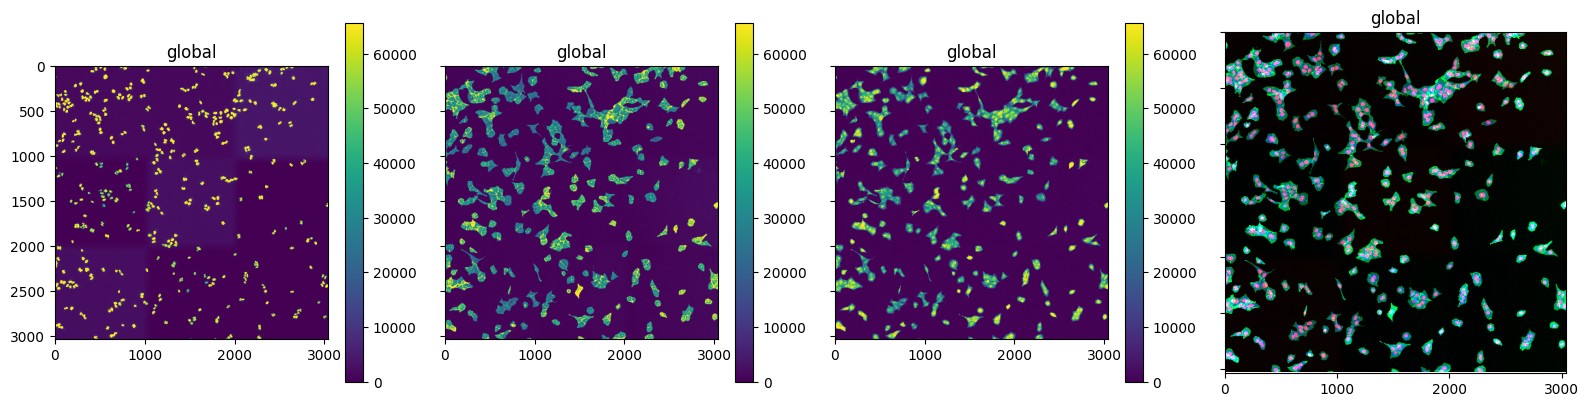

In [19]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4), sharex=True, sharey=True)

for idx in range(3):
    sdata.pl.render_images("czi", channel=idx).pl.show(ax=axs[idx])


sdata.pl.render_images("czi").pl.show(ax=axs[3])
plt.tight_layout()

## Run sopa

We can now run sopa. Sopa first creates smaller image patches that can be passed to cellpose, using the `sopa.make_image_patches` method. Subsquently, we can run the cellpose wrapper `sopa.segmentation.cellpose`. Note that you can also pass your own pretrained models to via the `pretrained_model="/path/to/pretrained/model"` argument. Here, we are using the default `cyto3` model.

In [21]:
sopa.make_image_patches(sdata, patch_width=500, patch_overlap=50, image_key="czi")

[INFO] (sopa.patches._patches) 49 patches were added to sdata['image_patches']


In [22]:
# Set dask as parallelization backend
sopa.settings.parallelization_backend = "dask"

sopa.segmentation.cellpose(sdata, channels=[1, 0], diameter=50, model_type="cyto3", image_key="czi")

# Runs in ca. 30s on MacOS/M3

[INFO] (sopa._settings) Using dask backend
/Users/lucas-diedrich/anaconda3/envs/sopa/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 54649 instead
  warnings.warn(


[                                        ] | 0% Completed |  0.4s

/Users/lucas-diedrich/anaconda3/envs/sopa/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/lucas-diedrich/anaconda3/envs/sopa/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/lucas-diedrich/anaconda3/envs/sopa/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `d

[INFO] (sopa.segmentation._stainings) Found 754 total cells
Resolving conflicts: 100%|██████████| 984/984 [00:00<00:00, 7647.23it/s]
[INFO] (sopa.segmentation._stainings) Added 579 cell boundaries in sdata['cellpose_boundaries']


We can inspect the cell segmentation in a smaller patch and we can see that the model performed well on this dataset.

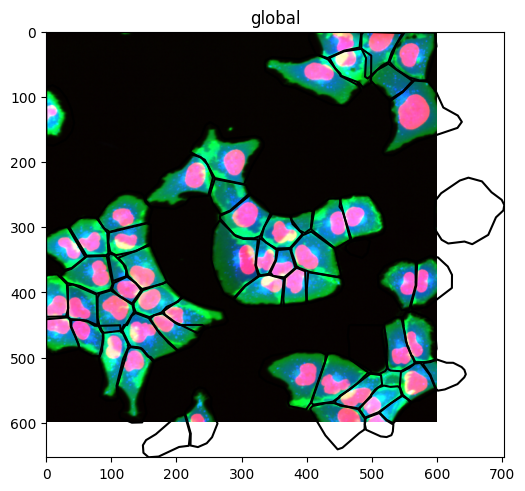

In [ ]:
(
    sdata.query.bounding_box(
        axes=("x", "y"),
        min_coordinate=np.array([0, 0]),
        max_coordinate=np.array([600, 600]),
        target_coordinate_system="global",
    )
    .pl.render_images("czi")
    .pl.render_shapes("cellpose_boundaries", fill_alpha=0, outline_alpha=1)
    .pl.show()
)

## Write shapes

In many cases, we are now interested in exporting the obtained shapes to a Leica Microdissection Microscope. We can use the `dvpio.write.write_lmd` function to export shapes in a compatible format. The function wraps the py-LMD package {cite:p}`Sparcs2023`. 

The function also relies on adding calibration points

In [24]:
sdata

SpatialData object, with associated Zarr store: /Users/lucas-diedrich/Documents/Projects/scverse/spatialdata/spatialdata-io/dvp-io/dvp-io/docs/tutorials/data/scportrait-czi.sdata.zarr
├── Images
│     └── 'czi': DataArray[cyx] (3, 3038, 3040)
└── Shapes
      ├── 'cellpose_boundaries': GeoDataFrame shape: (579, 1) (2D shapes)
      └── 'image_patches': GeoDataFrame shape: (49, 3) (2D shapes)
with coordinate systems:
    ▸ 'global', with elements:
        czi (Images), cellpose_boundaries (Shapes), image_patches (Shapes)

In [40]:
cell_shapes = sdata.shapes["cellpose_boundaries"]

We will also need to select calibration points in the image. 



In [ ]:
## Uncomment to select calibration points interactively
# interactive = Interactive(sdata)
# interactive.run()

![Interactive point selection in napari](../_static/img/006_sopa-point-selection.gif)

In [41]:
## Uncomment to select interactively selected calibration points
# calibration_points = sdata.points["calibration_points_image"]


# Use these points for reproducibility
calibration_points = sd.models.PointsModel.parse(
    np.array([[251.03580019, 151.55537058], [1999.99218284, 36.1721564], [109.75405585, 2953.58610685]])
)

Lastly, we need to define an affine transformation that is used to translate the image coordinates into LMD coordinates. 

In [31]:
affine_transformation = np.array([[0, -10, 0], [10, 0, 0], [0, 0, 1]])

We can use this information to write an LMD-compatible xml file that contains the segmented cells as shapes

In [32]:
write_lmd("./data/lmd.xml", cell_shapes, calibration_points, affine_transformation)

[0. 0.]
[     0. -10000.]
[10000.     0.]
